In [1]:
from torchsummary                    import summary
from datetime                        import datetime
from src.data.to_tensor              import ToTensor
from src.data.mrw_dataset            import MRWDataset
from src.data.create_data_loaders    import create_data_loaders
from src.nn.archs                    import CNN_EPSILON
from src.nn.training.utils           import Trainer
from src.nn.losses.weighted_mse_loss import WeightedMSELoss
from src.nn.results.utils            import plot_losses

import random
import torch
import torch.nn           as nn
import numpy              as np
import src.ctes.str_ctes  as sctes
import src.ctes.num_ctes  as nctes
import src.nn.path_ctes   as pctes

# Random Seed

In [2]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Model choice

In [3]:
builder    = CNN_EPSILON
labels     = builder.LABELS
model_name = "Example"

# Timestamp

In [4]:
timestamp = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
arch_name  = builder.__name__
hyperparams_path = f"../../../data/models/hyperparams_{arch_name}_{timestamp}.npz"
model_path = f"../../../data/models/model_{arch_name}_{timestamp}"
losses_path = f"../../../data/models/losses_{arch_name}_{timestamp}.npz"
print(timestamp)
print(arch_name)

2024_03_22__11_19_12
CNN_EPSILON


# Hyperparameters

In [5]:
n_epochs   = 2     # Number of epochs
batch_size = 6       # Batch size

test_size  = 0.2     # Whole dataset testing size
valid_size = 0.2     # Training dataset validation size

lr = 0.001           # Learning rate
weight_decay = 1e-5  # L2 regularization

# Dataset

In [6]:
data_path = pctes.DATAPATH

In [7]:
transform = ToTensor()
sample_size = nctes.LEN_SAMPLE
data = MRWDataset(data_path, transform, sample_size, labels)

In [8]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

# Cuda

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


# Model Summary

In [10]:
sample_size = nctes.LEN_SAMPLE
dropout_probs=[]
model = builder(input_size=sample_size, dropout_probs=dropout_probs)
model.to(device=device)

summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Sequential: 1-2                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-3                         [-1, 32, 16384]           --
├─Sequential: 1-4                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─BatchNorm1d: 2-8                  [-1, 64, 16381]           128
|    └─ReLU: 2-9                         [-1, 64, 16381]           --
├─AvgPoo

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Sequential: 1-2                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-3                         [-1, 32, 16384]           --
├─Sequential: 1-4                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─BatchNorm1d: 2-8                  [-1, 64, 16381]           128
|    └─ReLU: 2-9                         [-1, 64, 16381]           --
├─AvgPoo

# Criterion

In [11]:
criterion = nn.MSELoss()
print(criterion)

MSELoss()


# Optimizer

In [12]:
params = model.parameters()
optimizer = torch.optim.Adam(params, lr, weight_decay = weight_decay)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)


# Hyperparameters Backup

In [13]:
np.savez(hyperparams_path, 
         len           = len(data), 
         test_size     = test_size, 
         valid_size    = valid_size, 
         epochs        = n_epochs, 
         batch_size    = batch_size, 
         criterion     = str(criterion), 
         optimizer     = str(optimizer), 
         lr            = lr,
         seed          = seed,
         weight_decay  = weight_decay, 
         dropout_probs = dropout_probs, 
         model_name    = model_name,
         arch_name     = arch_name,
         labels        = labels)

# Traning

In [14]:
train_losses, valid_losses = Trainer.train(n_epochs, train_loader, valid_loader, model, criterion, optimizer, device, model_path, losses_path)

Epoch 1/2 ...
Training ...


  0%|          | 0/1366 [00:00<?, ?it/s]

 19%|█▉        | 258/1366 [00:59<04:16,  4.32it/s]


KeyboardInterrupt: 

# Loss plot

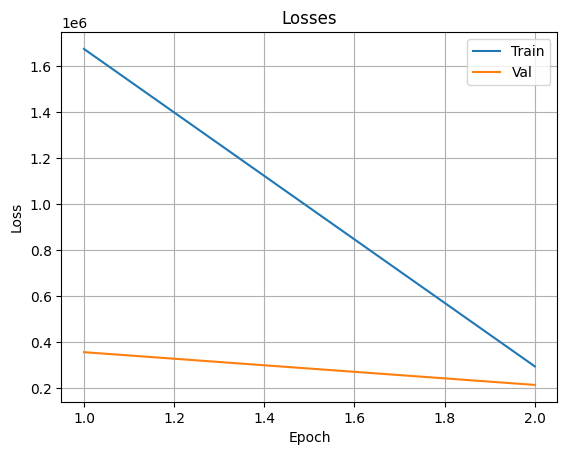

In [ ]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])